In [27]:
import pandas as pd

df = pd.read_csv("cs-training.csv")

df.drop(columns=["Unnamed: 0"], inplace=True)
df = df.fillna({
    'MonthlyIncome': df['MonthlyIncome'].median(),
    'NumberOfDependents': df['NumberOfDependents'].mode()[0]
})

df = df[df['age'] > 0]
df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: min(x, 1.0))

debt_ratio_cap = df['DebtRatio'].quantile(0.99)
income_cap = df['MonthlyIncome'].quantile(0.99)
df['DebtRatio'] = df['DebtRatio'].apply(lambda x: min(x, debt_ratio_cap))
df['MonthlyIncome'] = df['MonthlyIncome'].apply(lambda x: min(x, income_cap))

df['NumberOfDependents'] = df['NumberOfDependents'].apply(lambda x: min(x, 10))

for col in ['NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']:
    df[col] = df[col].apply(lambda x: min(x, 10))

df.drop_duplicates(inplace=True)

print("Cleaned dataset shape:", df.shape)
df.head()

Cleaned dataset shape: (149229, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,23000.0,7,0,1,0,0.0


In [28]:
df.to_csv("cleaned_cs-training.csv")

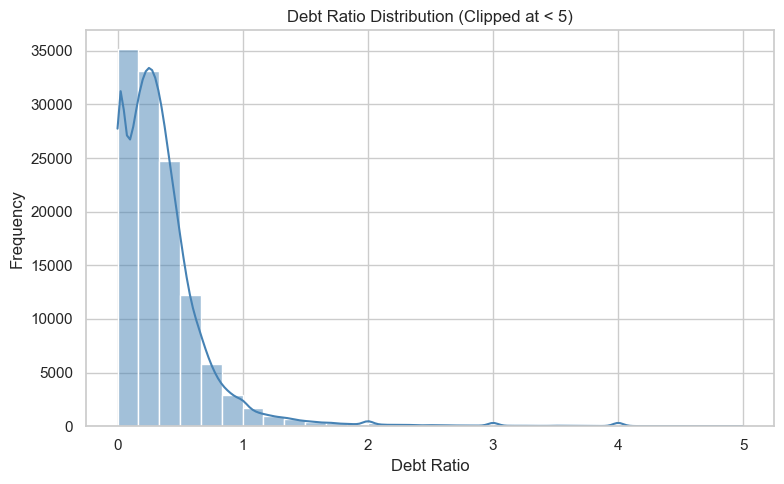

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data=df[df['DebtRatio'] < 5], x='DebtRatio', bins=30, kde=True, color='steelblue')  # Filter applied here
plt.title('Debt Ratio Distribution (Clipped at < 5)')
plt.xlabel('Debt Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

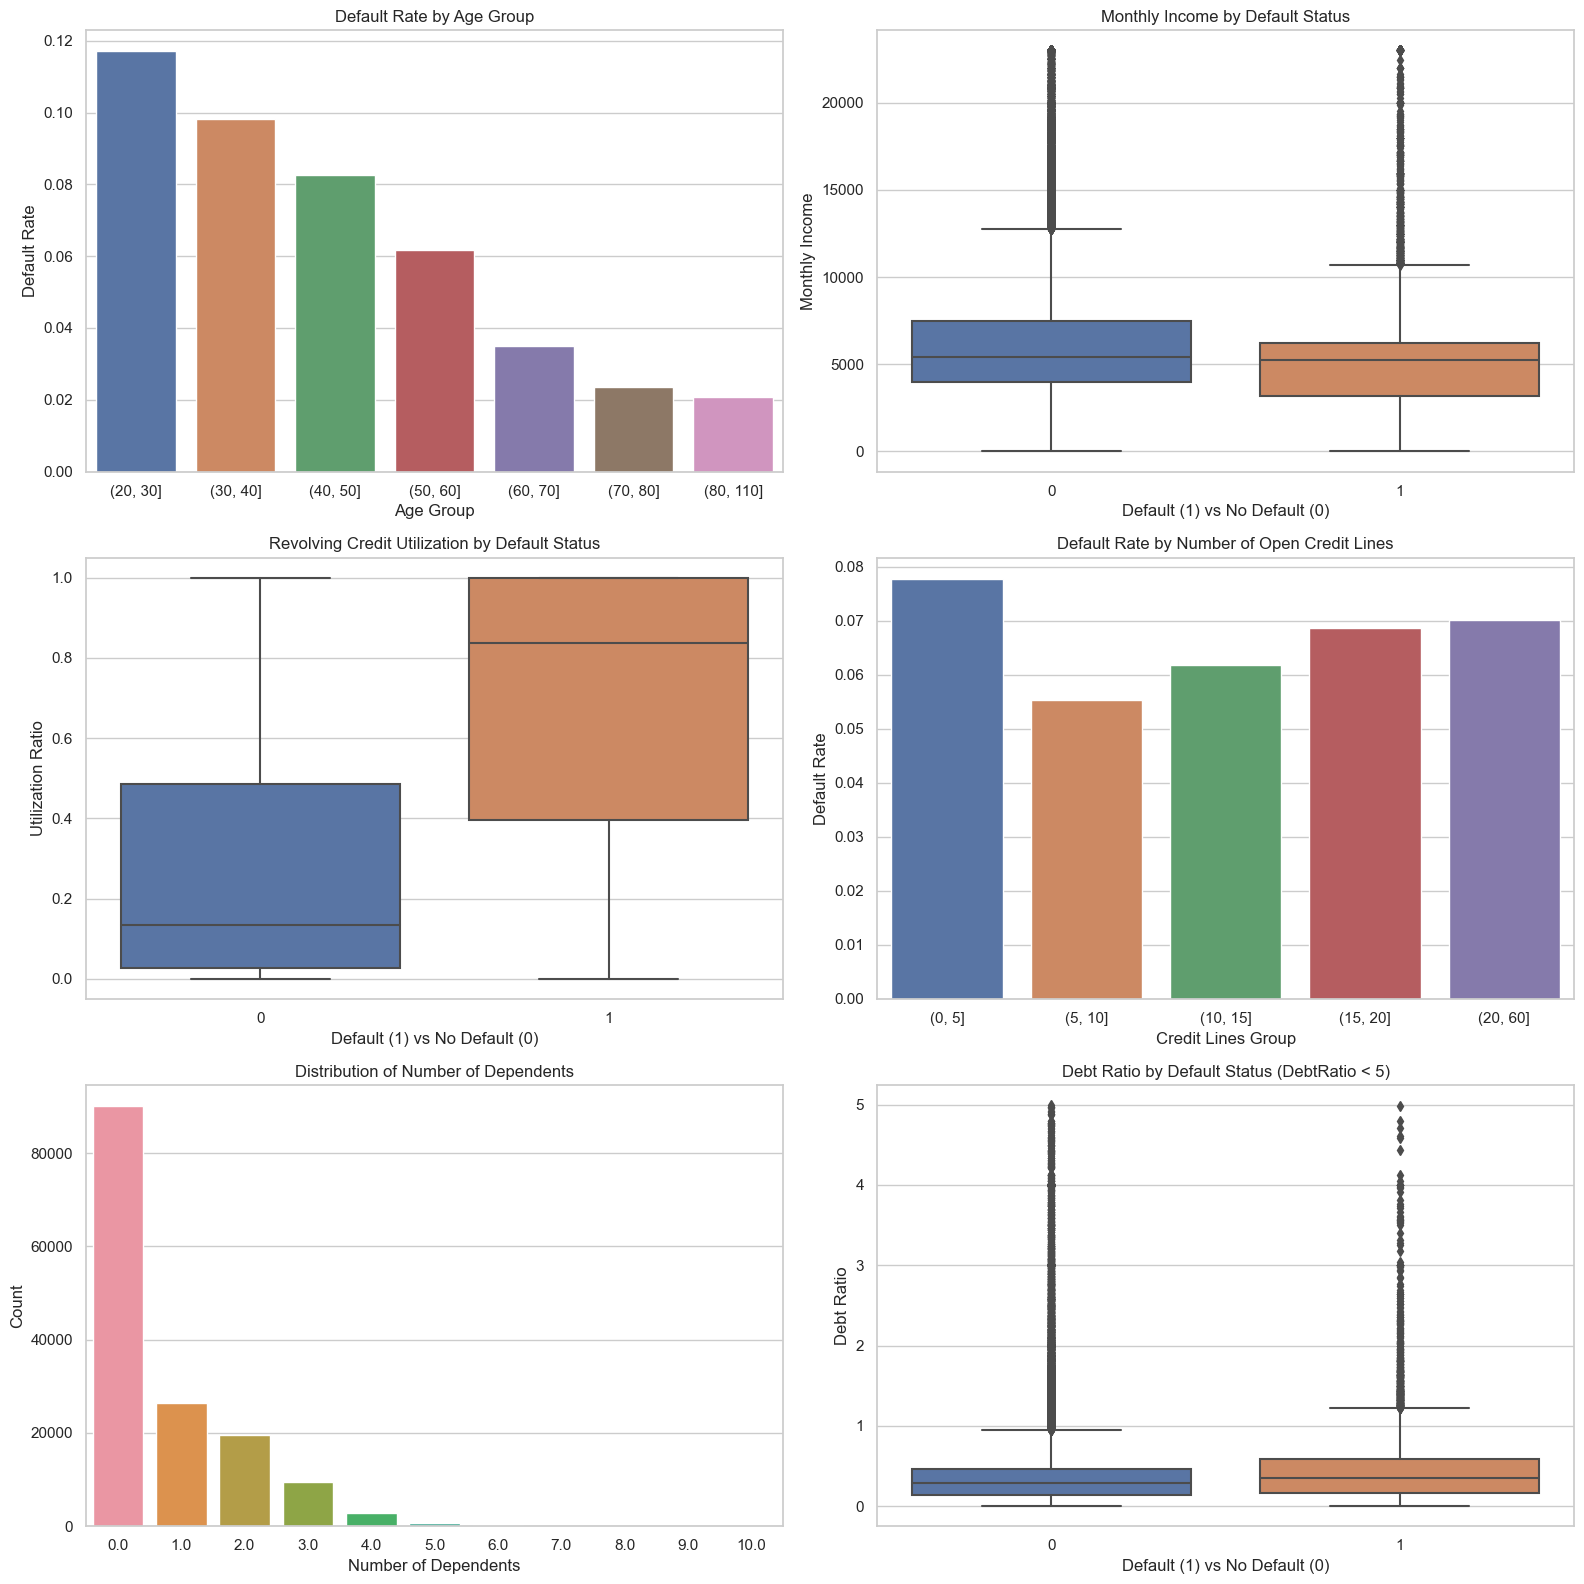

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70, 80, 110])

fig, axes = plt.subplots(3, 2, figsize=(16, 16))

age_default = df.groupby('age_group')['SeriousDlqin2yrs'].mean().reset_index()
sns.barplot(ax=axes[0, 0], data=age_default, x='age_group', y='SeriousDlqin2yrs')
axes[0, 0].set_title('Default Rate by Age Group')
axes[0, 0].set_ylabel('Default Rate')
axes[0, 0].set_xlabel('Age Group')

sns.boxplot(ax=axes[0, 1], data=df, x='SeriousDlqin2yrs', y='MonthlyIncome')
axes[0, 1].set_title('Monthly Income by Default Status')
axes[0, 1].set_xlabel('Default (1) vs No Default (0)')
axes[0, 1].set_ylabel('Monthly Income')

sns.boxplot(ax=axes[1, 0], data=df, x='SeriousDlqin2yrs', y='RevolvingUtilizationOfUnsecuredLines')
axes[1, 0].set_title('Revolving Credit Utilization by Default Status')
axes[1, 0].set_xlabel('Default (1) vs No Default (0)')
axes[1, 0].set_ylabel('Utilization Ratio')

credit_bins = pd.cut(df['NumberOfOpenCreditLinesAndLoans'], bins=[0, 5, 10, 15, 20, 60])
credit_default = df.groupby(credit_bins)['SeriousDlqin2yrs'].mean().reset_index()
sns.barplot(ax=axes[1, 1], data=credit_default, x='NumberOfOpenCreditLinesAndLoans', y='SeriousDlqin2yrs')
axes[1, 1].set_title('Default Rate by Number of Open Credit Lines')
axes[1, 1].set_ylabel('Default Rate')
axes[1, 1].set_xlabel('Credit Lines Group')

sns.countplot(ax=axes[2, 0], data=df, x='NumberOfDependents')
axes[2, 0].set_title('Distribution of Number of Dependents')
axes[2, 0].set_xlabel('Number of Dependents')
axes[2, 0].set_ylabel('Count')

sns.boxplot(ax=axes[2, 1], data=df[df['DebtRatio'] < 5], x='SeriousDlqin2yrs', y='DebtRatio')
axes[2, 1].set_title('Debt Ratio by Default Status (DebtRatio < 5)')
axes[2, 1].set_xlabel('Default (1) vs No Default (0)')
axes[2, 1].set_ylabel('Debt Ratio')

plt.tight_layout()
plt.show()

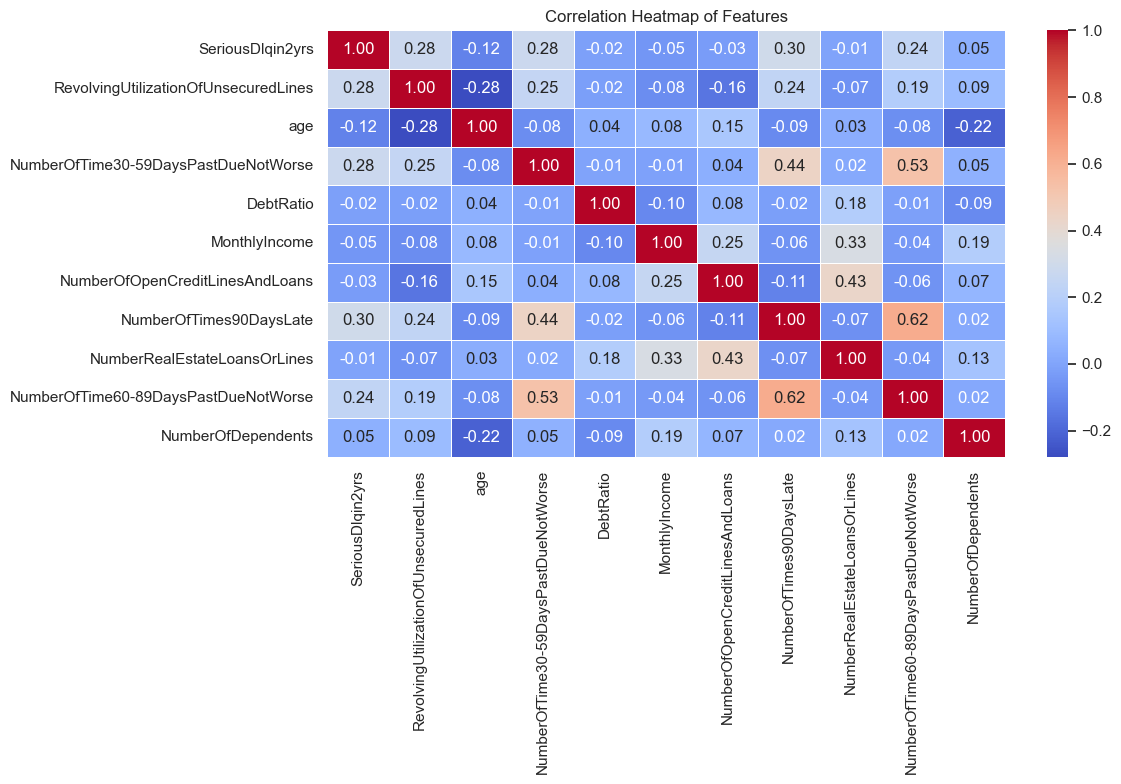

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

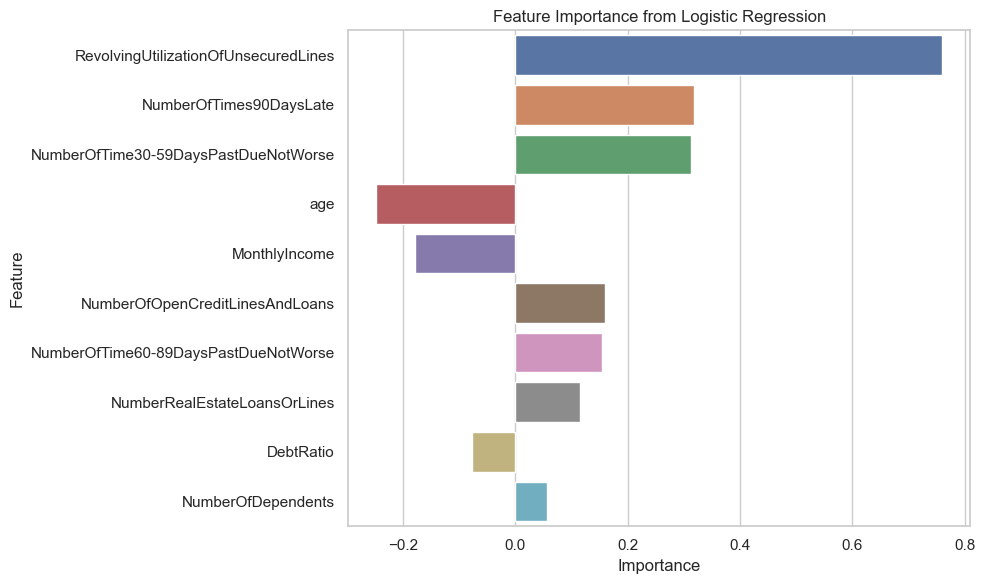

In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

X = df.drop(columns=['SeriousDlqin2yrs', 'age_group'])
y = df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': logreg.coef_[0]
}).sort_values(by='Importance', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance from Logistic Regression')
plt.tight_layout()
plt.show()

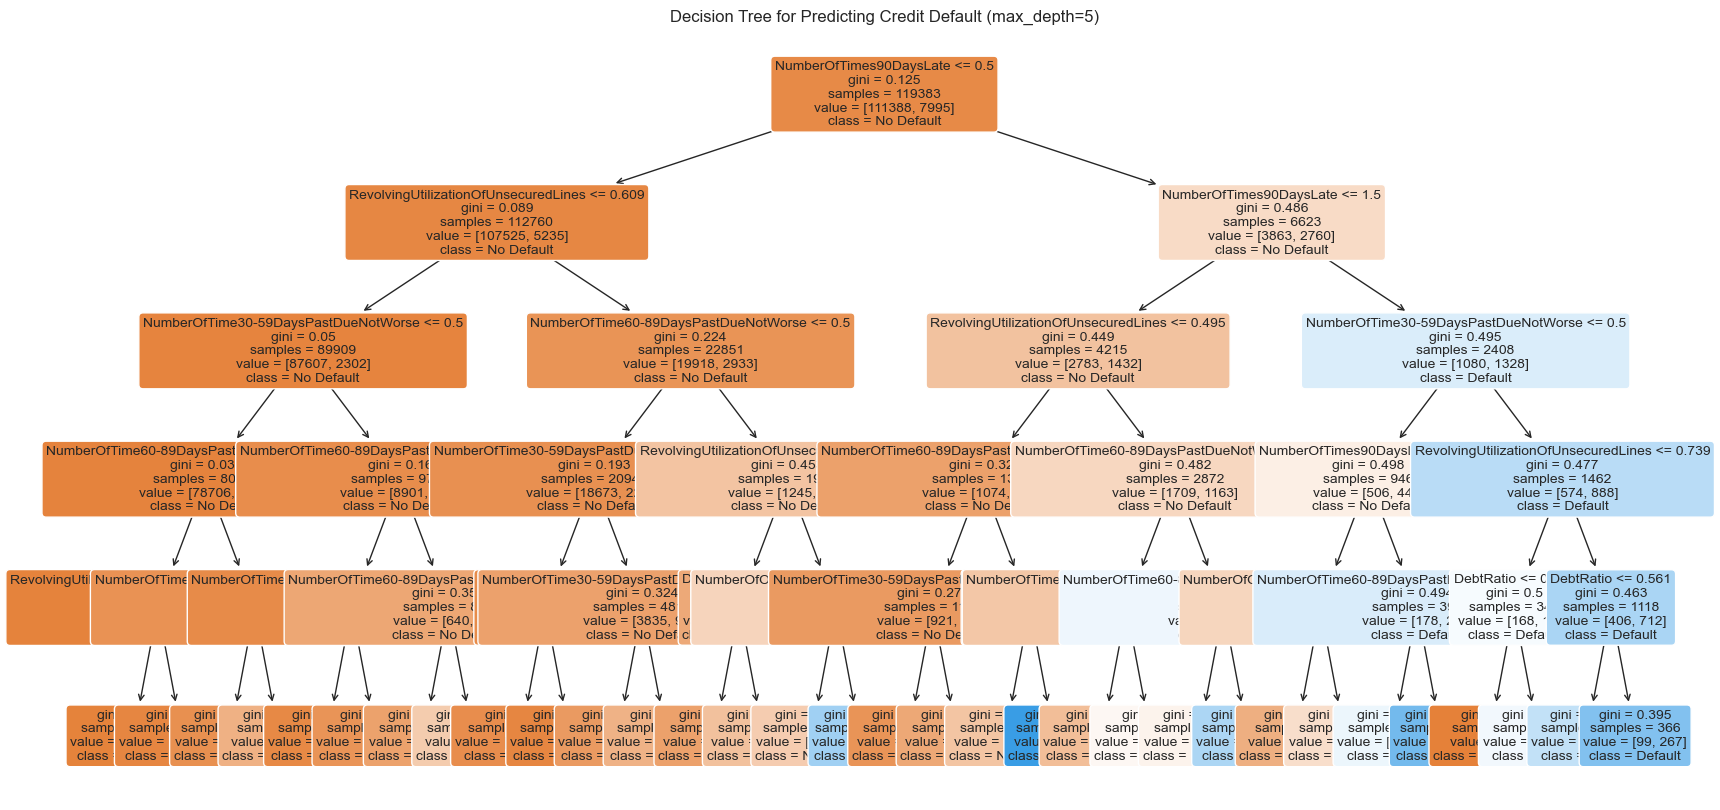

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree_model,
          feature_names=X.columns.tolist(),  # Ensure it's a list
          class_names=["No Default", "Default"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree for Predicting Credit Default (max_depth=5)")
plt.show()

In [15]:
pip install graphviz


  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/91/4c/e0ce1ef95d4000ebc1c11801f9b944fa5910ecc15b5e351865763d8657f8/graphviz-0.21-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/47.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/47.3 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.3 kB ? eta -:--:--
   ---------------------------------- ----- 41.0/47.3 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 47.3/47.3 kB 398.5 kB/s eta 0:00:00


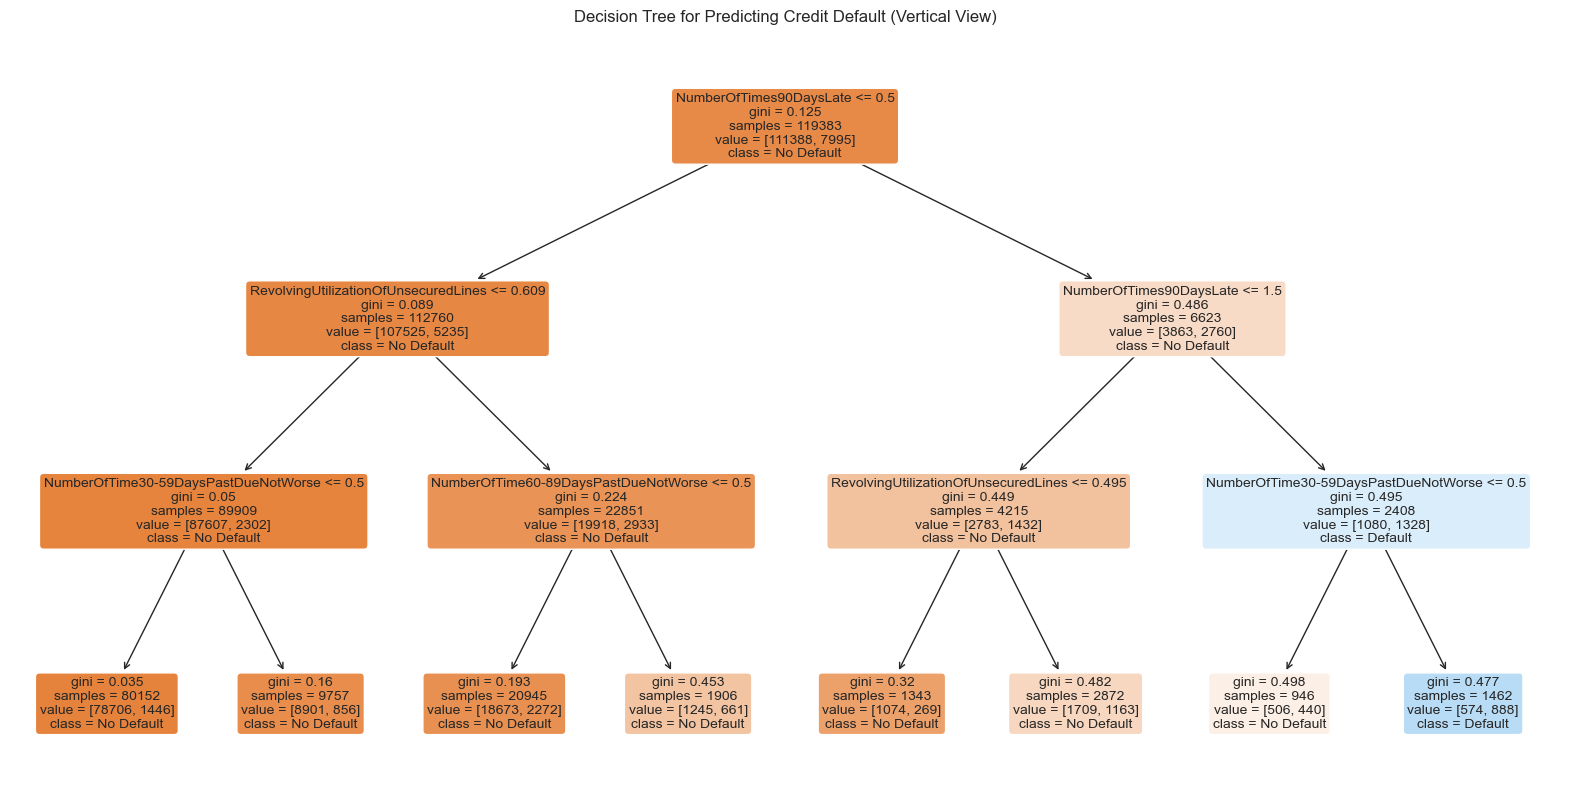

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [35]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import graphviz

tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

feature_names_list = X.columns.tolist()

plt.figure(figsize=(20, 10))
plot_tree(tree_model,
          feature_names=feature_names_list,
          class_names=["No Default", "Default"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree for Predicting Credit Default (Vertical View)")
plt.show()

dot_data = export_graphviz(tree_model,
                           out_file=None,
                           feature_names=feature_names_list,
                           class_names=["No Default", "Default"],
                           filled=True,
                           rounded=True,
                           special_characters=True)

dot_lines = dot_data.splitlines()
dot_lines.insert(1, 'rankdir=LR;')  
dot_data_horizontal = '\n'.join(dot_lines)

graph = graphviz.Source(dot_data_horizontal)
graph.render("tree_output", format="png", cleanup=True)
graph